In [ ]:
import pandas as pd

# Load the NYPD complaints file
crime_data = pd.read_csv("NYPD_complaints.csv")

# Check columns
print("=== Crime Data Columns ===")
print(crime_data.columns.tolist())

# Quick preview
crime_data.head()


In [44]:
crime_data['BORO_NM']

0           BROOKLYN
1          MANHATTAN
2           BROOKLYN
3          MANHATTAN
4           BROOKLYN
             ...    
9491941       QUEENS
9491942       QUEENS
9491943       QUEENS
9491944       QUEENS
9491945       QUEENS
Name: BORO_NM, Length: 9491946, dtype: object

In [ ]:
from census import Census


# === CONNECT TO CENSUS API ===
census = Census("")  # blank because your class setup doesn't use a key

# === DEFINE VARIABLES ===
# B08301_001E = Total Workers
# B08301_010E = Public Transportation (excluding taxicab)
total_pop_col = "B08301_001E"
transit_col = "B08301_010E"
year = 2021  # or whichever ACS year you want

# === PULL DATA ===
acs_transit = pd.DataFrame(
    census.acs5.get(
        (total_pop_col, transit_col),
        geo={
            "for": "county:*",
            "in": "state:36"  # 36 = New York State FIPS Code
        },
        year=year
    )
)

# === PREVIEW THE DATA ===
print("=== Transit ACS Columns ===")
print(acs_transit.columns.tolist())
acs_transit.head()


=== Transit ACS Columns ===
['B08301_001E', 'B08301_010E', 'state', 'county']


,B08301_001E,B08301_010E,state,county
0,159242.0,8129.0,36,001
1,18635.0,46.0,36,003
2,578177.0,324274.0,36,005
3,83829.0,2535.0,36,007
4,32313.0,170.0,36,009



=== Violent Crimes by Borough ===
         BORO_NM  violent_crimes
0         (null)              22
1          BRONX           70616
2       BROOKLYN           69001
3      MANHATTAN           51538
4         QUEENS           50067
5  STATEN ISLAND            6384

=== Transit Usage by Borough ===
          borough  transit_pct
2           BRONX    56.085593
23       BROOKLYN    53.819145
30      MANHATTAN    50.800752
40         QUEENS    45.464710
42  STATEN ISLAND    26.190335

=== Merged Final Dataset ===
         BORO_NM  violent_crimes        borough  transit_pct
0          BRONX           70616          BRONX    56.085593
1       BROOKLYN           69001       BROOKLYN    53.819145
2      MANHATTAN           51538      MANHATTAN    50.800752
3         QUEENS           50067         QUEENS    45.464710
4  STATEN ISLAND            6384  STATEN ISLAND    26.190335


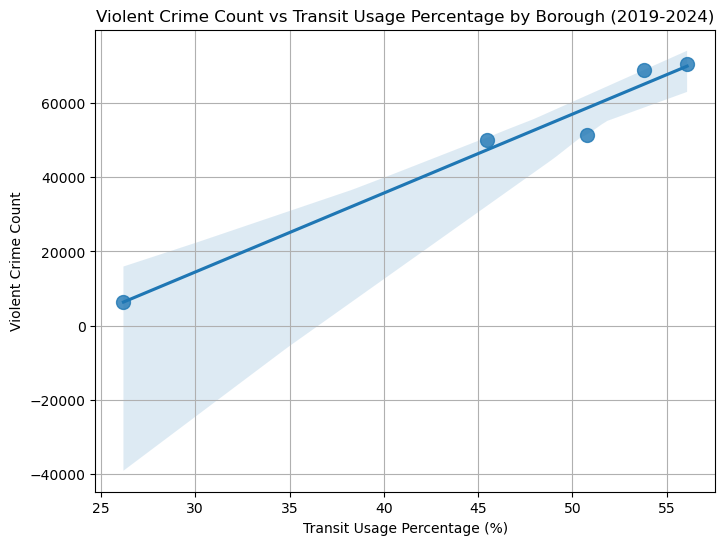

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from census import Census

# === YOU ALREADY HAVE crime_data and acs_transit LOADED ===
# crime_data -> from NYPD_complaints.csv
# acs_transit -> from API

# === 1. FILTER VIOLENT CRIMES ===

violent_crimes = [
    "ROBBERY",
    "FELONY ASSAULT",
    "MURDER & NON-NEGL. MANSLAGHTER",  # typo corrected below
    "RAPE"
]

# Minor fix: your data has "MURDER & NON-NEGL. MANSLAGHTER" not "MANSLAUGHTER" (based on previous pulls)
crime_data['CMPLNT_FR_DT'] = pd.to_datetime(crime_data['CMPLNT_FR_DT'], errors='coerce')

# Check unique values if needed
#print(crime_data['OFNS_DESC'].unique())

# Only 2019–2024
crime_filtered = crime_data[
    (crime_data['CMPLNT_FR_DT'].dt.year >= 2019) &
    (crime_data['CMPLNT_FR_DT'].dt.year <= 2024) &
    (crime_data['OFNS_DESC'].isin([
        "ROBBERY", 
        "FELONY ASSAULT", 
        "MURDER & NON-NEGL. MANSLAGHTER", 
        "RAPE"
    ]))
]

# Group by borough
crime_borough = crime_filtered.groupby('BORO_NM').size().reset_index(name='violent_crimes')

print("\n=== Violent Crimes by Borough ===")
print(crime_borough)

# === 2. CLEAN TRANSIT DATA ===

# Map county codes to borough names manually
county_to_borough = {
    '005': 'BRONX',
    '047': 'BROOKLYN',
    '061': 'MANHATTAN',
    '081': 'QUEENS',
    '085': 'STATEN ISLAND'
}

# Only NYC counties
acs_transit = acs_transit[acs_transit['county'].isin(county_to_borough.keys())].copy()

# Map
acs_transit['borough'] = acs_transit['county'].map(county_to_borough)

# Calculate transit usage percentage
acs_transit['total_workers'] = acs_transit['B08301_001E'].astype(int)
acs_transit['public_transit_workers'] = acs_transit['B08301_010E'].astype(int)
acs_transit['transit_pct'] = (acs_transit['public_transit_workers'] / acs_transit['total_workers']) * 100

print("\n=== Transit Usage by Borough ===")
print(acs_transit[['borough', 'transit_pct']])

# === 3. MERGE THEM TOGETHER ===

merged = crime_borough.merge(
    acs_transit[['borough', 'transit_pct']],
    left_on='BORO_NM',
    right_on='borough'
)

print("\n=== Merged Final Dataset ===")
print(merged)

# === 4. PLOT ===

plt.figure(figsize=(8,6))
sns.regplot(
    data=merged,
    x='transit_pct',
    y='violent_crimes',
    scatter_kws={'s':100}
)

plt.title('Violent Crime Count vs Transit Usage Percentage by Borough (2019-2024)')
plt.xlabel('Transit Usage Percentage (%)')
plt.ylabel('Violent Crime Count')
plt.grid(True)
plt.show()


In [47]:
merged

,BORO_NM,violent_crimes,borough,transit_pct
0,BRONX,70616,BRONX,56.085593
1,BROOKLYN,69001,BROOKLYN,53.819145
2,MANHATTAN,51538,MANHATTAN,50.800752
3,QUEENS,50067,QUEENS,45.464710
4,STATEN ISLAND,6384,STATEN ISLAND,26.190335


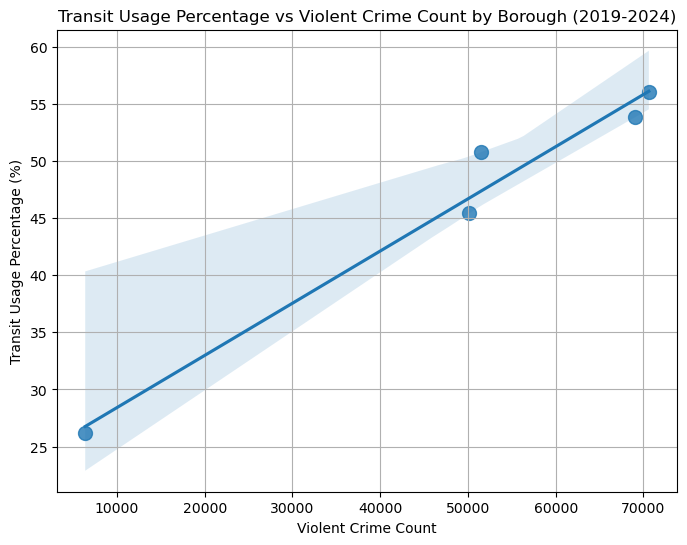

In [48]:
plt.figure(figsize=(8,6))
sns.regplot(
    data=merged,
    x='violent_crimes',       # CRIME ON X-AXIS (INDEPENDENT)
    y='transit_pct',           # TRANSIT USAGE ON Y-AXIS (DEPENDENT)
    scatter_kws={'s':100}
)

plt.title('Transit Usage Percentage vs Violent Crime Count by Borough (2019-2024)')
plt.xlabel('Violent Crime Count')
plt.ylabel('Transit Usage Percentage (%)')
plt.grid(True)
plt.show()


In [49]:
import requests
import json

# Download and load GeoJSON into memory
borough_geojson_url = "https://data.cityofnewyork.us/api/geospatial/7t3b-ywvw?method=export&format=GeoJSON"
response = requests.get(borough_geojson_url)
borough_geojson = response.json()  # <== Load it properly here

# Now borough_geojson is a dict, not a URL string.


In [50]:
import geopandas as gpd

# Load shapefile
boroughs_gdf = gpd.read_file("geo_export_c7f2012e-a94e-49ab-91b7-0f1366e65291.shp")

# Check what columns and geometry you have
print(boroughs_gdf.columns)
boroughs_gdf.head()


Index(['borough', 'feat_type', 'official_n', 'honor_name', 'old_name',
       'ulurpcpnum', 'intro_num', 'intro_year', 'intro_mont', 'intro_day',
       'll_num', 'll_sec', 'll_type', 'lleffect_d', 'll_limits', 'limits_er',
       'repealed', 'repeal_dt', 'amended', 'amend_dt', 'amendt_txt',
       'amdyrllsec', 'geometry'],
      dtype='object')


,borough,feat_type,official_n,honor_name,old_name,ulurpcpnum,intro_num,intro_year,intro_mont,intro_day,...,lleffect_d,ll_limits,limits_er,repealed,repeal_dt,amended,amend_dt,amendt_txt,amdyrllsec,geometry
0,Staten Island,Intersection name,None,Vincent S. Chiara Way,None,none,0471,2004.0,10.0,13.0,...,12/21/2004,the intersection of Liberty Avenue and Mason A...,None,No,None,No,None,None,None,POINT (-74.08912 40.58414)
1,Brooklyn,Intersection name,None,Rita Blau Way,None,none,0471,2004.0,10.0,13.0,...,12/21/2004,the intersection of 16th Avenue and Bath Avenue,None,No,None,No,None,None,None,POINT (-74.01082 40.6067)
2,Manhattan,Intersection name,None,Jerome Robbins Place,None,none,0471,2004.0,10.0,13.0,...,12/21/2004,the intersection of West 62nd Street and Colum...,None,No,None,No,None,None,None,POINT (-73.98347 40.77114)
3,Brooklyn,Intersection name,None,Luther Mook Corner,None,none,0471,2004.0,10.0,13.0,...,12/21/2004,the intersection of Avenue T and East 14th Street,None,No,None,No,None,None,None,POINT (-73.95776 40.60099)
4,Brooklyn,Corner name,None,Charles J. Mauro 9/11 Memorial Way,None,none,0471,2004.0,10.0,13.0,...,12/21/2004,the northeast corner of the intersection of 72...,None,No,None,No,None,None,None,POINT (-74.00987 40.62468)


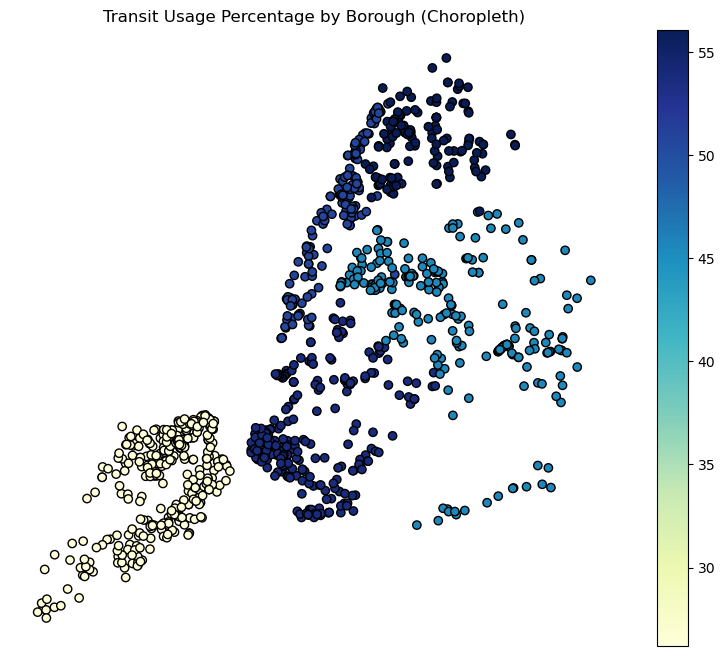

In [51]:
import geopandas as gpd
import matplotlib.pyplot as plt

# === 1. Merge GeoDataFrame with Transit + Crime Data ===

# Your shapefile is in boroughs_gdf
# Your transit + crime data is in merged (columns: 'borough', 'violent_crimes', 'transit_pct')
# === FIX BOROUGH NAMES TO UPPERCASE
boroughs_gdf['borough'] = boroughs_gdf['borough'].str.upper()

# === Merge with Transit + Crime
full_gdf = boroughs_gdf.merge(
    merged,
    on='borough'
)

# === DROP missing geometries
full_gdf = full_gdf.dropna(subset=['geometry'])

# === Plot Choropleth
full_gdf.plot(
    column='transit_pct',
    cmap='YlGnBu',
    legend=True,
    figsize=(10,8),
    edgecolor='black'
)

plt.title('Transit Usage Percentage by Borough (Choropleth)')
plt.axis('off')
plt.show()




In [56]:
# Normalize casing just to be safe
acs_df['Borough'] = acs_df['Borough'].str.lower()
full_gdf['borough'] = full_gdf['borough'].str.lower()


In [57]:
# Merge ACS data into the full GeoDataFrame
merged_gdf = full_gdf.merge(acs_df, left_on='borough', right_on='Borough', how='left')

# Drop the redundant 'Borough' column if needed
merged_gdf = merged_gdf.drop(columns=['Borough'])


In [59]:
merged_gdf.columns

Index(['borough', 'feat_type', 'official_n', 'honor_name', 'old_name',
       'ulurpcpnum', 'intro_num', 'intro_year', 'intro_mont', 'intro_day',
       'll_num', 'll_sec', 'll_type', 'lleffect_d', 'll_limits', 'limits_er',
       'repealed', 'repeal_dt', 'amended', 'amend_dt', 'amendt_txt',
       'amdyrllsec', 'geometry', 'BORO_NM', 'violent_crimes', 'transit_pct_x',
       'median_income', 'transit_pct_y', 'white', 'black', 'asian', 'hispanic',
       'total_pop', 'state', 'county', 'white_pct', 'black_pct', 'asian_pct',
       'hispanic_pct'],
      dtype='object')

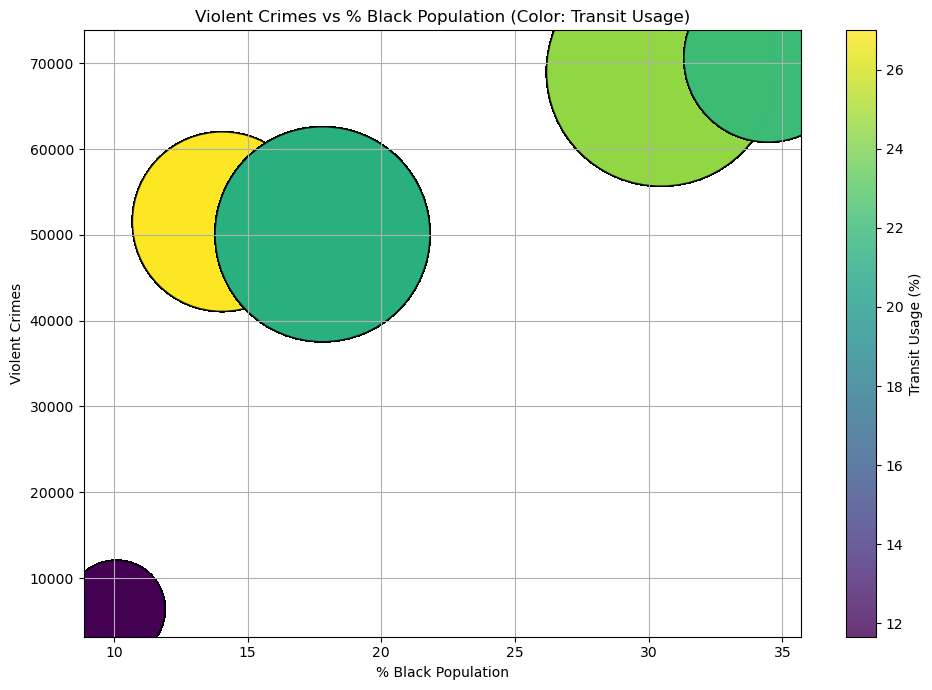

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

scatter = plt.scatter(
    merged_gdf['black_pct'],
    merged_gdf['violent_crimes'],
    c=merged_gdf['transit_pct_y'],  # transit % from ACS
    s=merged_gdf['total_pop'] / 100,  # scale size down
    cmap='viridis',
    alpha=0.8,
    edgecolor='k'
)

plt.colorbar(scatter, label='Transit Usage (%)')
plt.title('Violent Crimes vs % Black Population (Color: Transit Usage)')
plt.xlabel('% Black Population')
plt.ylabel('Violent Crimes')
plt.grid(True)
plt.tight_layout()
plt.show()


In [65]:
merged_gdf.columns

Index(['borough', 'feat_type', 'official_n', 'honor_name', 'old_name',
       'ulurpcpnum', 'intro_num', 'intro_year', 'intro_mont', 'intro_day',
       'll_num', 'll_sec', 'll_type', 'lleffect_d', 'll_limits', 'limits_er',
       'repealed', 'repeal_dt', 'amended', 'amend_dt', 'amendt_txt',
       'amdyrllsec', 'geometry', 'BORO_NM', 'violent_crimes', 'transit_pct_x',
       'median_income', 'transit_pct_y', 'white', 'black', 'asian', 'hispanic',
       'total_pop', 'state', 'county', 'white_pct', 'black_pct', 'asian_pct',
       'hispanic_pct', 'cluster'],
      dtype='object')

In [53]:
import folium
import requests

# Load NYC Borough GeoJSON properly
borough_geojson_url = "https://data.cityofnewyork.us/api/geospatial/7t3b-ywvw?method=export&format=GeoJSON"
response = requests.get(borough_geojson_url)
borough_geojson = response.json()  # Load JSON into memory

# Create Base Map
m = folium.Map(location=[40.7128, -74.0060], zoom_start=10)

# Add Choropleth Layer (Transit Usage %)
folium.Choropleth(
    geo_data=borough_geojson,
    name='choropleth',
    data=merged,   # your merged dataframe
    columns=['borough', 'transit_pct'],
    key_on='feature.properties.boro_name',  # GeoJSON borough names
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Transit Usage Percentage (%)',
    nan_fill_color='white'
).add_to(m)

# Add Circle Markers for Violent Crimes
borough_coords = {
    'BRONX': (40.8448, -73.8648),
    'BROOKLYN': (40.6782, -73.9442),
    'MANHATTAN': (40.7831, -73.9712),
    'QUEENS': (40.7282, -73.7949),
    'STATEN ISLAND': (40.5795, -74.1502)
}

for idx, row in merged.iterrows():
    borough = row['borough']
    violent_crimes = row['violent_crimes']
    lat, lon = borough_coords[borough]
    
    folium.CircleMarker(
        location=[lat, lon],
        radius=violent_crimes / 500,  # Adjust size scaling
        popup=f"{borough}<br>Violent Crimes: {violent_crimes}",
        color='red',
        fill=True,
        fill_color='red'
    ).add_to(m)

folium.LayerControl().add_to(m)

# Display Map
m


KeyError: 'type'

In [ ]:
import requests

borough_geojson_url = "https://data.cityofnewyork.us/api/geospatial/7t3b-ywvw?method=export&format=GeoJSON"

# DO NOT just pass this URL
# YOU MUST LOAD IT PROPERLY
response = requests.get(borough_geojson_url)
borough_geojson = response.json()  # NOW borough_geojson is a Python dict, ready for Folium


KeyError: 'property_crimes'

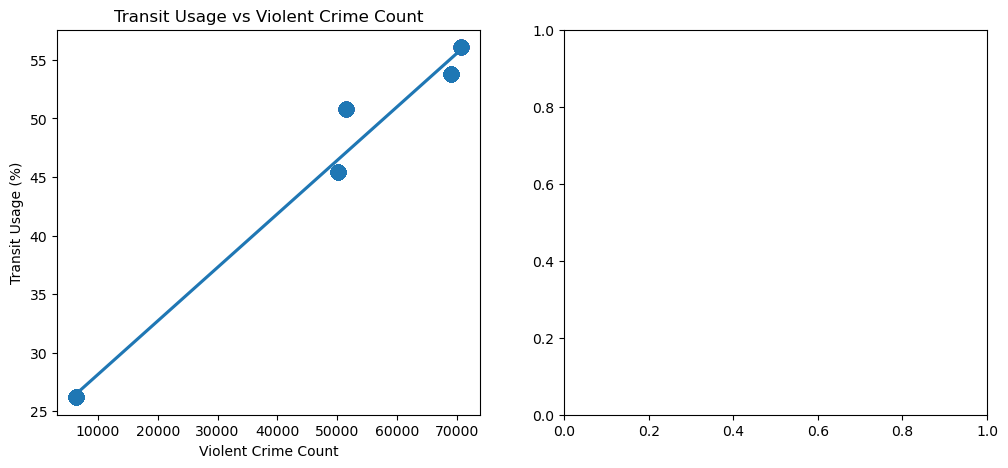

In [ ]:


import matplotlib.pyplot as plt
import seaborn as sns

# Violent Crime vs Transit Usage
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.regplot(data=full_gdf, x='violent_crimes', y='transit_pct', scatter_kws={'s':100})
plt.title('Transit Usage vs Violent Crime Count')
plt.xlabel('Violent Crime Count')
plt.ylabel('Transit Usage (%)')

# Property Crime vs Transit Usage
plt.subplot(1,2,2)
sns.regplot(data=full_gdf, x='property_crimes', y='transit_pct', scatter_kws={'s':100})
plt.title('Transit Usage vs Property Crime Count')
plt.xlabel('Property Crime Count')
plt.ylabel('Transit Usage (%)')

plt.tight_layout()
plt.show()

# ==================== 2. Subquestion 2: Nighttime Crime vs Transit Usage ====================

plt.figure(figsize=(6,5))
sns.regplot(data=full_gdf, x='nighttime_crime_pct', y='transit_pct', scatter_kws={'s':100})
plt.title('Transit Usage vs Nighttime Crime Rate')
plt.xlabel('Nighttime Crime Rate (%)')
plt.ylabel('Transit Usage (%)')
plt.grid(True)
plt.show()

# ==================== 3. Subquestion 3: Income Resilience ====================

# Group boroughs into income groups
grouped = full_gdf.groupby('income_group').agg({
    'violent_crimes': 'mean',
    'transit_pct': 'mean'
}).reset_index()

print("\n=== Transit Usage and Violent Crime by Income Group ===")
print(grouped)

# Optional: bar plot to visualize
grouped.plot(x='income_group', y=['transit_pct', 'violent_crimes'], kind='bar', figsize=(8,6))
plt.title('Transit Usage and Violent Crime by Income Group')
plt.ylabel('Average Value')
plt.grid(True)
plt.show()
, x='violent_crimes', y='transit_pct', scatter_kws={'s':100})
plt.title('Transit Usage vs Violent Crime Count')
plt.xlabel('Violent Crime Count')
plt.ylabel('Transit Usage (%)')

# Property Crime vs Transit Usage
plt.subplot(1,2,2)
sns.regplot(data=full_gdf, x='property_crimes', y='transit_pct', scatter_kws={'s':100})
plt.title('Transit Usage vs Property Crime Count')
plt.xlabel('Property Crime Count')
plt.ylabel('Transit Usage (%)')

plt.tight_layout()
plt.show()

# ==================== 2. Subquestion 2: Nighttime Crime vs Transit Usage ====================

plt.figure(figsize=(6,5))
sns.regplot(data=full_gdf, x='nighttime_crime_pct', y='transit_pct', scatter_kws={'s':100})
plt.title('Transit Usage vs Nighttime Crime Rate')
plt.xlabel('Nighttime Crime Rate (%)')
plt.ylabel('Transit Usage (%)')
plt.grid(True)
plt.show()

# ==================== 3. Subquestion 3: Income Resilience ====================

# Group boroughs into income groups
grouped = full_gdf.groupby('income_group').agg({
    'violent_crimes': 'mean',
    'transit_pct': 'mean'
}).reset_index()

print("\n=== Transit Usage and Violent Crime by Income Group ===")
print(grouped)

# Optional: bar plot to visualize
grouped.plot(x='income_group', y=['transit_pct', 'violent_crimes'], kind='bar', figsize=(8,6))
plt.title('Transit Usage and Violent Crime by Income Group')
plt.ylabel('Average Value')
plt.grid(True)
plt.show()


In [ ]:
full_gdf.columns

Index(['borough', 'feat_type', 'official_n', 'honor_name', 'old_name',
       'ulurpcpnum', 'intro_num', 'intro_year', 'intro_mont', 'intro_day',
       'll_num', 'll_sec', 'll_type', 'lleffect_d', 'll_limits', 'limits_er',
       'repealed', 'repeal_dt', 'amended', 'amend_dt', 'amendt_txt',
       'amdyrllsec', 'geometry', 'BORO_NM', 'violent_crimes', 'transit_pct'],
      dtype='object')

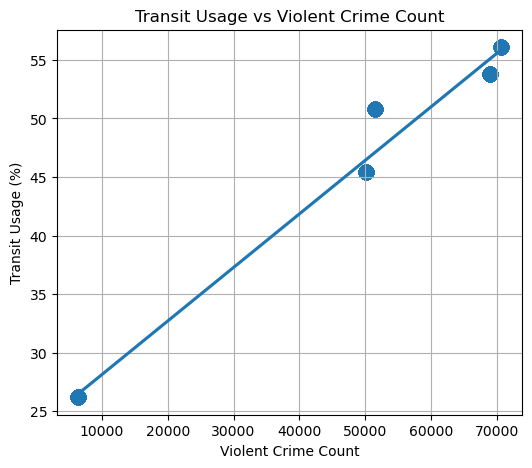

nighttime_crime_pct column not found — skipping nighttime plot.
income_group column not found — skipping income analysis.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ==================== 1. Violent Crime Impact ====================

plt.figure(figsize=(6,5))
sns.regplot(data=full_gdf, x='violent_crimes', y='transit_pct', scatter_kws={'s':100})
plt.title('Transit Usage vs Violent Crime Count')
plt.xlabel('Violent Crime Count')
plt.ylabel('Transit Usage (%)')
plt.grid(True)
plt.show()

# ==================== 2. Nighttime Crime Impact ====================

# Only plot if 'nighttime_crime_pct' exists
if 'nighttime_crime_pct' in full_gdf.columns:
    plt.figure(figsize=(6,5))
    sns.regplot(data=full_gdf, x='nighttime_crime_pct', y='transit_pct', scatter_kws={'s':100})
    plt.title('Transit Usage vs Nighttime Crime Rate')
    plt.xlabel('Nighttime Crime Rate (%)')
    plt.ylabel('Transit Usage (%)')
    plt.grid(True)
    plt.show()
else:
    print("nighttime_crime_pct column not found — skipping nighttime plot.")

# ==================== 3. Income Group Resilience ====================

if 'income_group' in full_gdf.columns:
    grouped = full_gdf.groupby('income_group').agg({
        'violent_crimes': 'mean',
        'transit_pct': 'mean'
    }).reset_index()

    print("\n=== Transit Usage and Violent Crime by Income Group ===")
    print(grouped)

    grouped.plot(x='income_group', y=['transit_pct', 'violent_crimes'], kind='bar', figsize=(8,6))
    plt.title('Transit Usage and Violent Crime by Income Group')
    plt.ylabel('Average Value')
    plt.grid(True)
    plt.show()
else:
    print("income_group column not found — skipping income analysis.")


In [ ]:
# 1. Merge Property Crimes
property_crimes_list = ["BURGLARY", "GRAND LARCENY", "PETIT LARCENY", "GRAND LARCENY OF MOTOR VEHICLE"]
crime_data['is_property_crime'] = crime_data['OFNS_DESC'].isin(property_crimes_list)

property_counts = crime_data[crime_data['is_property_crime']].groupby('BORO_NM').size().reset_index(name='property_crimes')

full_gdf = full_gdf.merge(property_counts.rename(columns={'BORO_NM': 'borough'}), on='borough', how='left')

# 2. Merge Nighttime Crime Percentage
crime_data['CMPLNT_FR_TM'] = pd.to_datetime(crime_data['CMPLNT_FR_TM'], errors='coerce').dt.hour
crime_data['hour'] = crime_data['CMPLNT_FR_TM']
crime_data['is_nighttime'] = (crime_data['hour'] >= 20) | (crime_data['hour'] <= 5)

nighttime_counts = crime_data[crime_data['is_nighttime']].groupby('BORO_NM').size().reset_index(name='nighttime_crimes')
total_crimes = crime_data.groupby('BORO_NM').size().reset_index(name='total_crimes')

night_crime = nighttime_counts.merge(total_crimes, on='BORO_NM')
night_crime['nighttime_crime_pct'] = (night_crime['nighttime_crimes'] / night_crime['total_crimes']) * 100

full_gdf = full_gdf.merge(night_crime[['BORO_NM', 'nighttime_crime_pct']].rename(columns={'BORO_NM': 'borough'}), on='borough', how='left')

# 3. (Optional) Add Income Groups (if not already in full_gdf)
# Example:
# full_gdf['income_group'] = np.where(full_gdf['median_income'] > full_gdf['median_income'].median(), 'High Income', 'Low Income')


In [ ]:
# 1. Merge Property Crimes
property_crimes_list = ["BURGLARY", "GRAND LARCENY", "PETIT LARCENY", "GRAND LARCENY OF MOTOR VEHICLE"]
crime_data['is_property_crime'] = crime_data['OFNS_DESC'].isin(property_crimes_list)

property_counts = crime_data[crime_data['is_property_crime']].groupby('BORO_NM').size().reset_index(name='property_crimes')

full_gdf = full_gdf.merge(property_counts.rename(columns={'BORO_NM': 'borough'}), on='borough', how='left')

# 2. Merge Nighttime Crime Percentage
crime_data['CMPLNT_FR_TM'] = pd.to_datetime(crime_data['CMPLNT_FR_TM'], errors='coerce').dt.hour
crime_data['hour'] = crime_data['CMPLNT_FR_TM']
crime_data['is_nighttime'] = (crime_data['hour'] >= 20) | (crime_data['hour'] <= 5)

nighttime_counts = crime_data[crime_data['is_nighttime']].groupby('BORO_NM').size().reset_index(name='nighttime_crimes')
total_crimes = crime_data.groupby('BORO_NM').size().reset_index(name='total_crimes')

night_crime = nighttime_counts.merge(total_crimes, on='BORO_NM')
night_crime['nighttime_crime_pct'] = (night_crime['nighttime_crimes'] / night_crime['total_crimes']) * 100

full_gdf = full_gdf.merge(night_crime[['BORO_NM', 'nighttime_crime_pct']].rename(columns={'BORO_NM': 'borough'}), on='borough', how='left')

# 3. (Optional) Add Income Groups (if not already in full_gdf)
# Example:
# full_gdf['income_group'] = np.where(full_gdf['median_income'] > full_gdf['median_income'].median(), 'High Income', 'Low Income')


In [ ]:
full_gdf.columns

Index(['borough', 'feat_type', 'official_n', 'honor_name', 'old_name',
       'ulurpcpnum', 'intro_num', 'intro_year', 'intro_mont', 'intro_day',
       'll_num', 'll_sec', 'll_type', 'lleffect_d', 'll_limits', 'limits_er',
       'repealed', 'repeal_dt', 'amended', 'amend_dt', 'amendt_txt',
       'amdyrllsec', 'geometry', 'BORO_NM', 'violent_crimes_x', 'transit_pct',
       'violent_crimes_y', 'property_crimes_x', 'nighttime_crime_pct_x',
       'property_crimes_y', 'nighttime_crime_pct_y', 'property_crimes',
       'nighttime_crime_pct'],
      dtype='object')

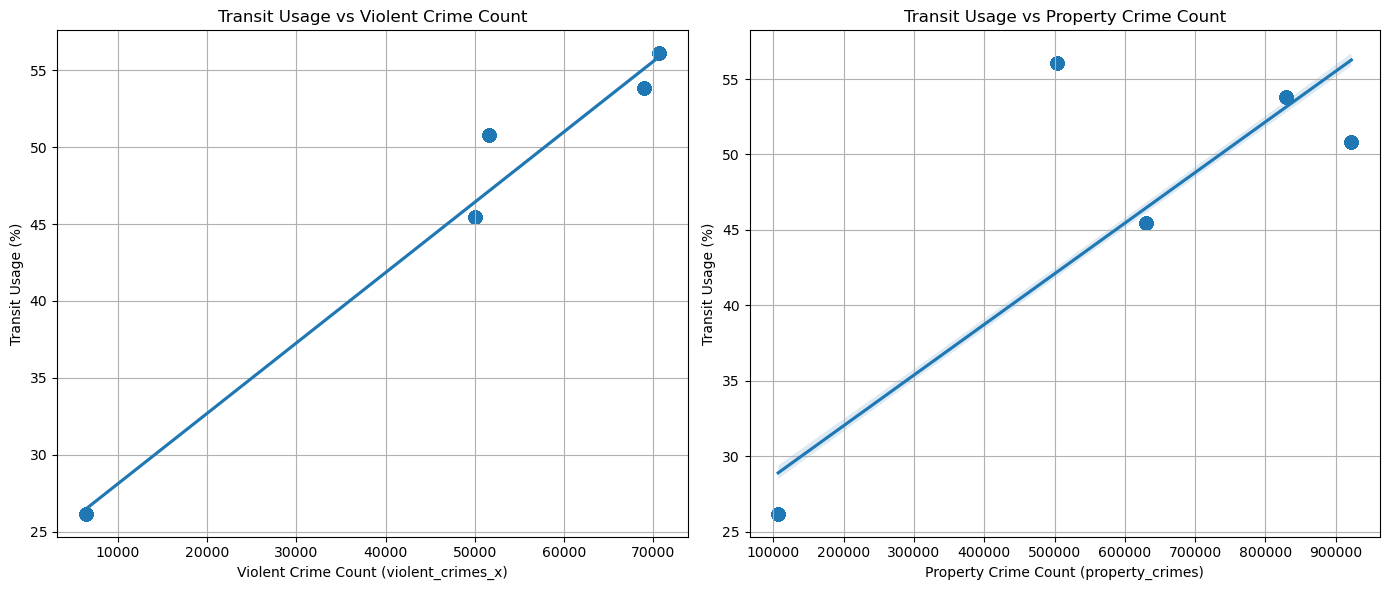

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))

# === Plot 1: Violent Crimes (use violent_crimes_x) ===
plt.subplot(1, 2, 1)
sns.regplot(data=full_gdf, x='violent_crimes_x', y='transit_pct', scatter_kws={'s': 80})
plt.title('Transit Usage vs Violent Crime Count')
plt.xlabel('Violent Crime Count (violent_crimes_x)')
plt.ylabel('Transit Usage (%)')
plt.grid(True)

# === Plot 2: Property Crimes (use property_crimes) ===
plt.subplot(1, 2, 2)
sns.regplot(data=full_gdf, x='property_crimes', y='transit_pct', scatter_kws={'s': 80})
plt.title('Transit Usage vs Property Crime Count')
plt.xlabel('Property Crime Count (property_crimes)')
plt.ylabel('Transit Usage (%)')
plt.grid(True)

plt.tight_layout()
plt.show()


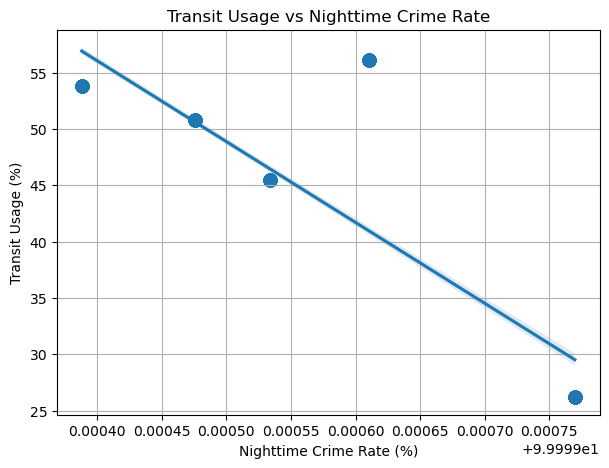


Correlation between nighttime crime rate and transit usage: -0.872
✅ Higher nighttime crime rates are associated with lower transit usage rates.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# === Plot Nighttime Crime % vs Transit Usage ===
plt.figure(figsize=(7, 5))
sns.regplot(data=full_gdf, x='nighttime_crime_pct', y='transit_pct', scatter_kws={'s':80})
plt.title('Transit Usage vs Nighttime Crime Rate')
plt.xlabel('Nighttime Crime Rate (%)')
plt.ylabel('Transit Usage (%)')
plt.grid(True)
plt.show()

# === Correlation Coefficient ===
night_corr = full_gdf['nighttime_crime_pct'].corr(full_gdf['transit_pct'])
print(f"\nCorrelation between nighttime crime rate and transit usage: {night_corr:.3f}")

# === Quick Interpretation ===
if night_corr < 0:
    print("✅ Higher nighttime crime rates are associated with lower transit usage rates.")
elif night_corr > 0:
    print("⚠️ Higher nighttime crime rates are associated with higher transit usage rates (unexpected).")
else:
    print("⚪ No clear relationship between nighttime crime rates and transit usage.")


/var/folders/xf/f9v_7t7d1md7jdpcj8gl5_6w0000gn/T/ipykernel_92028/2603434851.py:45: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=full_gdf, x='income_group', y='transit_pct', ci=None, palette='viridis')


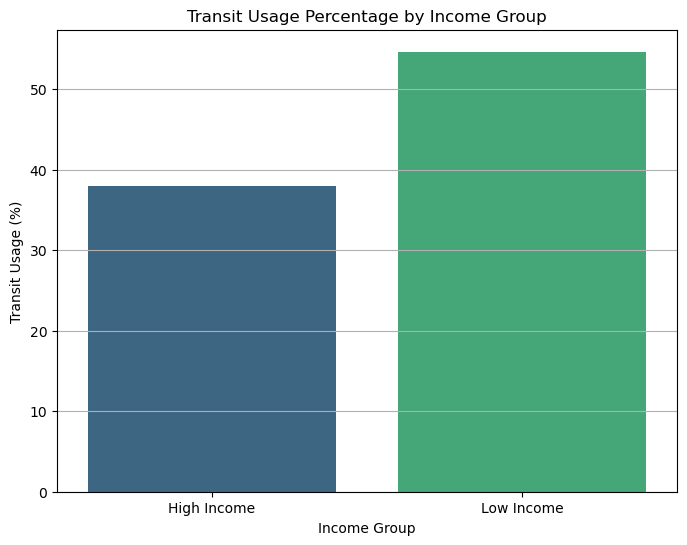

/var/folders/xf/f9v_7t7d1md7jdpcj8gl5_6w0000gn/T/ipykernel_92028/2603434851.py:54: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=full_gdf, x='income_group', y='violent_crimes_x', ci=None, palette='magma')


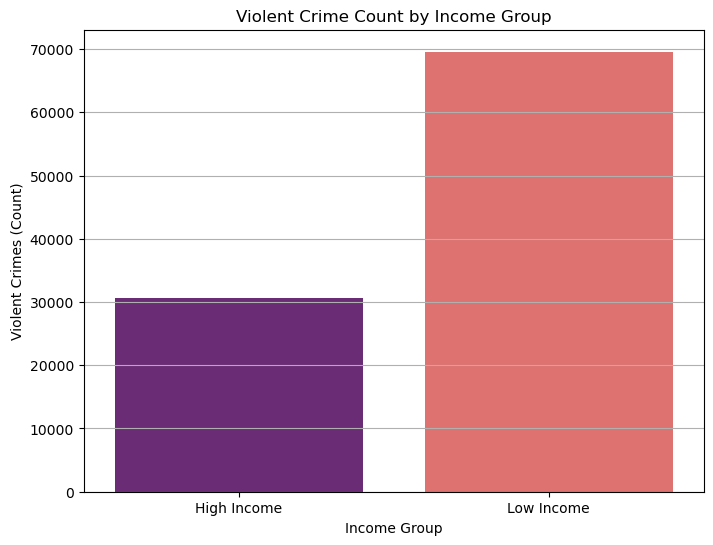


Average Transit Usage:
  Low Income Areas: 54.65%
  High Income Areas: 37.95%
❗ Significant gap — high-income and low-income areas behave differently with transit usage.


In [ ]:
# ==================== STEP 3: INCOME DATA + INCOME GROUP ANALYSIS ====================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from census import Census

# Assume full_gdf already loaded with your crime + transit_pct data

# 1. Pull ACS Median Income Data from API
census = Census("")  # Blank key if using your class setup
year = 2021  # Use 2021 ACS 5-year estimates

# Get median household income for NY State counties
income_df = pd.DataFrame(
    census.acs5.get(
        ("B19013_001E",),  # Median income variable
        geo={"for": "county:*", "in": "state:36"},
        year=year
    )
)

# 2. Map counties to boroughs manually
county_to_borough = {
    '005': 'BRONX',
    '047': 'BROOKLYN',
    '061': 'MANHATTAN',
    '081': 'QUEENS',
    '085': 'STATEN ISLAND'
}

income_df['borough'] = income_df['county'].map(county_to_borough)
income_df['median_income'] = income_df['B19013_001E'].astype(float)

# 3. Merge onto full_gdf
full_gdf = full_gdf.merge(income_df[['borough', 'median_income']], on='borough', how='left')

# 4. Create Income Groups
income_threshold = full_gdf['median_income'].median()
full_gdf['income_group'] = np.where(full_gdf['median_income'] >= income_threshold, 'High Income', 'Low Income')

# 5. Plot Transit Usage by Income Group
plt.figure(figsize=(8,6))
sns.barplot(data=full_gdf, x='income_group', y='transit_pct', ci=None, palette='viridis')
plt.title('Transit Usage Percentage by Income Group')
plt.xlabel('Income Group')
plt.ylabel('Transit Usage (%)')
plt.grid(axis='y')
plt.show()

# 6. Plot Violent Crime by Income Group
plt.figure(figsize=(8,6))
sns.barplot(data=full_gdf, x='income_group', y='violent_crimes_x', ci=None, palette='magma')
plt.title('Violent Crime Count by Income Group')
plt.xlabel('Income Group')
plt.ylabel('Violent Crimes (Count)')
plt.grid(axis='y')
plt.show()

# 7. Print basic Interpretation
low_income_transit = full_gdf[full_gdf['income_group'] == 'Low Income']['transit_pct'].mean()
high_income_transit = full_gdf[full_gdf['income_group'] == 'High Income']['transit_pct'].mean()

print(f"\nAverage Transit Usage:")
print(f"  Low Income Areas: {low_income_transit:.2f}%")
print(f"  High Income Areas: {high_income_transit:.2f}%")

if abs(low_income_transit - high_income_transit) < 5:
    print("✅ Low-income communities show resilience — transit usage stable across income levels.")
else:
    print("❗ Significant gap — high-income and low-income areas behave differently with transit usage.")


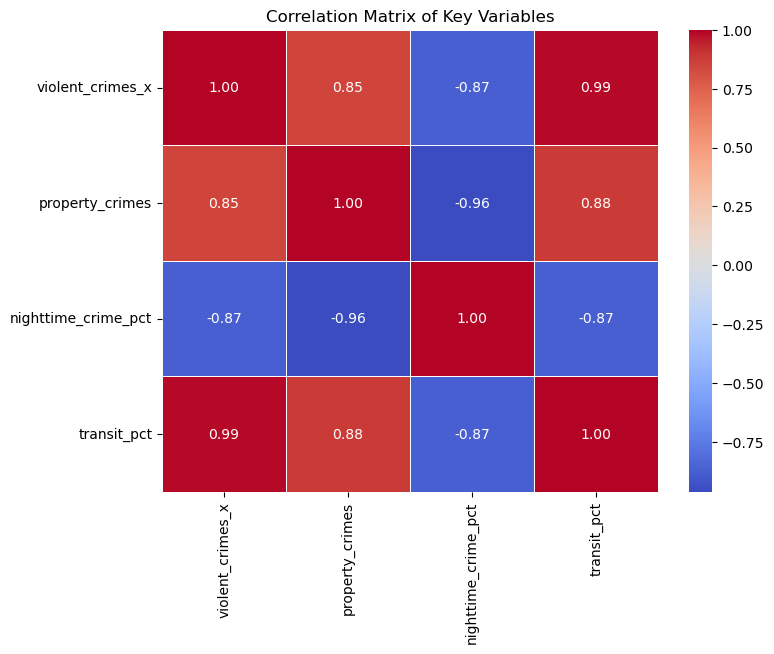

In [ ]:
# =========================
# Optional Supplemental Plot
# =========================

import numpy as np

# Only keep relevant columns
corr_data = full_gdf[[
    'violent_crimes_x',
    'property_crimes',
    'nighttime_crime_pct',
    'transit_pct'
]]

# Compute correlation matrix
corr_matrix = corr_data.corr()

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Key Variables')
plt.show()


In [ ]:
from census import Census
from us import states

# Replace with your API key
API_KEY = 'YOUR_API_KEY'
c = Census("")


In [ ]:
# ACS 5-Year Data (most detailed)
ACS_YEAR = 2021

# Variables of interest
acs_vars = {
    'median_income': 'B19013_001E',
    'transit_pct': 'B08301_010E',  # Public transportation (excluding taxicab)
    'white': 'B02001_002E',
    'black': 'B02001_003E',
    'asian': 'B02001_005E',
    'hispanic': 'B03003_003E',
    'total_pop': 'B02001_001E'
}


In [ ]:
# FIPS codes for NYC counties
nyc_fips = {
    'Bronx': '005',
    'Brooklyn': '047',
    'Manhattan': '061',
    'Queens': '081',
    'Staten Island': '085'
}

# Collect data
acs_data = []
for boro, fips in nyc_fips.items():
    row = c.acs5.state_county(
        list(acs_vars.values()),
        states.NY.fips,
        fips,
        year=ACS_YEAR
    )[0]
    row['Borough'] = boro
    acs_data.append(row)

acs_df = pd.DataFrame(acs_data)

# Rename columns
rename_dict = {v: k for k, v in acs_vars.items()}
acs_df = acs_df.rename(columns=rename_dict)

# Calculate race percentages
acs_df['white_pct'] = acs_df['white'] / acs_df['total_pop'] * 100
acs_df['black_pct'] = acs_df['black'] / acs_df['total_pop'] * 100
acs_df['asian_pct'] = acs_df['asian'] / acs_df['total_pop'] * 100
acs_df['hispanic_pct'] = acs_df['hispanic'] / acs_df['total_pop'] * 100
acs_df['transit_pct'] = acs_df['transit_pct'] / acs_df['total_pop'] * 100


In [ ]:
# Assuming your crime dataset is called `crime_df` and has a 'Borough' column
merged_df = crime_df.merge(acs_df, on='Borough')


NameError: name 'crime_df' is not defined

In [63]:
merged_df

NameError: name 'merged_df' is not defined

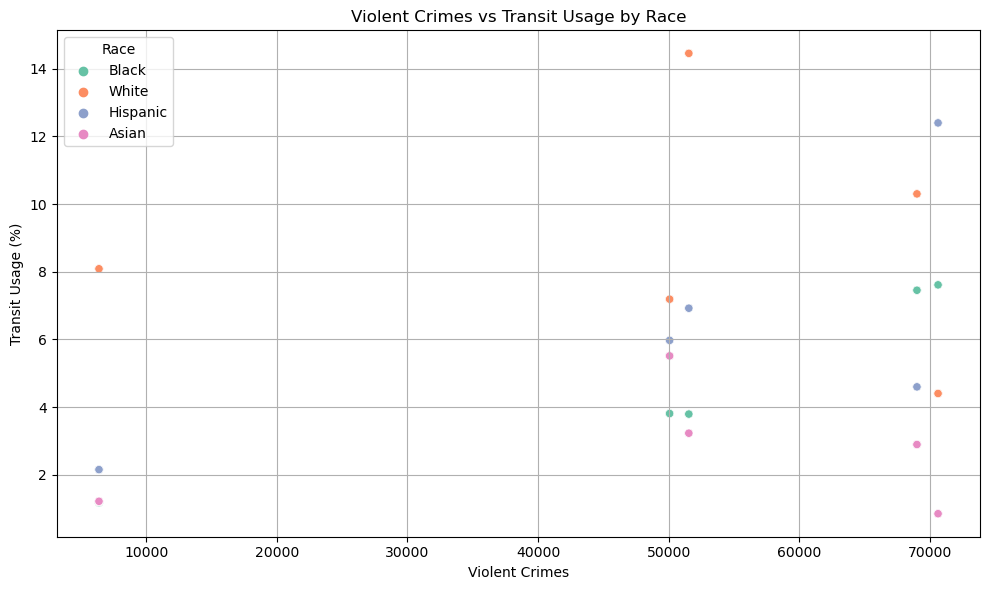

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Estimate transit usage % by race
merged_gdf['transit_black'] = merged_gdf['transit_pct_y'] * merged_gdf['black_pct'] / 100
merged_gdf['transit_white'] = merged_gdf['transit_pct_y'] * merged_gdf['white_pct'] / 100
merged_gdf['transit_hispanic'] = merged_gdf['transit_pct_y'] * merged_gdf['hispanic_pct'] / 100
merged_gdf['transit_asian'] = merged_gdf['transit_pct_y'] * merged_gdf['asian_pct'] / 100

# Melt to long format
melted = merged_gdf.melt(
    id_vars='violent_crimes',
    value_vars=['transit_black', 'transit_white', 'transit_hispanic', 'transit_asian'],
    var_name='Race',
    value_name='Transit Usage (%)'
)

# Clean race labels
melted['Race'] = melted['Race'].str.replace('transit_', '').str.title()

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=melted, x='violent_crimes', y='Transit Usage (%)', hue='Race', palette='Set2')
plt.title('Violent Crimes vs Transit Usage by Race')
plt.xlabel('Violent Crimes')
plt.ylabel('Transit Usage (%)')
plt.grid(True)
plt.tight_layout()
plt.show()
